In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random

## Linear SVM with SMO

In [12]:
# 辅助函数
def loadDataSet(fileName):
    """
    读取数据
    """
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():  #逐行读取，滤除空格等
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])  #添加数据
        labelMat.append(float(lineArr[2]))  #添加标签
    return dataMat, labelMat


def selectJrand(i, m):
    """
    随机选择alpha
    """
    j = i  #选择一个不等于i的j
    while (j == i):
        j = int(random.uniform(0, m))
    return j


def clipAlpha(aj, H, L):
    """
    修剪alpha
    """
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj


def showDataSet(dataMat, labelMat):
    """
    数据可视化
    """
    data_plus = []  #正样本
    data_minus = []  #负样本
    for i in range(len(dataMat)):
        if labelMat[i] > 0:
            data_plus.append(dataMat[i])
        else:
            data_minus.append(dataMat[i])
    data_plus_np = np.array(data_plus)  #转换为numpy矩阵
    data_minus_np = np.array(data_minus)  #转换为numpy矩阵
    plt.scatter(np.transpose(data_plus_np)[0],
                np.transpose(data_plus_np)[1])  #正样本散点图
    plt.scatter(
        np.transpose(data_minus_np)[0],
        np.transpose(data_minus_np)[1])  #负样本散点图
    plt.show()


def showClassifer(dataMat, w, b):
    """
    分类结果可视化
    """
    #绘制样本点
    data_plus = []  #正样本
    data_minus = []  #负样本
    for i in range(len(dataMat)):
        if labelMat[i] > 0:
            data_plus.append(dataMat[i])
        else:
            data_minus.append(dataMat[i])
    data_plus_np = np.array(data_plus)  #转换为numpy矩阵
    data_minus_np = np.array(data_minus)  #转换为numpy矩阵
    plt.scatter(np.transpose(data_plus_np)[0],
                np.transpose(data_plus_np)[1],
                s=30,
                alpha=0.7)  #正样本散点图
    plt.scatter(np.transpose(data_minus_np)[0],
                np.transpose(data_minus_np)[1],
                s=30,
                alpha=0.7)  #负样本散点图
    #绘制直线
    x1 = max(dataMat)[0]
    x2 = min(dataMat)[0]
    a1, a2 = w
    b = float(b)
    a1 = float(a1[0])
    a2 = float(a2[0])
    y1, y2 = (-b - a1 * x1) / a2, (-b - a1 * x2) / a2
    plt.plot([x1, x2], [y1, y2])
    #找出支持向量点
    for i, alpha in enumerate(alphas):
        if abs(alpha) > 0:
            x, y = dataMat[i]
            plt.scatter([x], [y],
                        s=150,
                        c='none',
                        alpha=0.7,
                        linewidth=1.5,
                        edgecolor='red')
    plt.show()

In [13]:
# 简化版SMO算法（使用随机搜索alpha）
def smoSimple(dataMatIn, classLabels, C, toler, maxIter):
    dataMatrix = np.mat(dataMatIn)  #转换为numpy的mat存储
    labelMat = np.mat(classLabels).transpose()
    b = 0  #初始化b参数，统计dataMatrix的维度
    m, n = np.shape(dataMatrix)
    alphas = np.mat(np.zeros((m, 1)))  #初始化alpha参数，设为0
    iter_num = 0  #初始化迭代次数
    while (iter_num < maxIter):  #最多迭代matIter次
        alphaPairsChanged = 0
        for i in range(m):
            #步骤1：计算误差Ei
            fXi = float(
                np.multiply(alphas, labelMat).T *
                (dataMatrix * dataMatrix[i, :].T)) + b
            Ei = fXi - float(labelMat[i])
            if ((labelMat[i] * Ei < -toler) and
                (alphas[i] < C)) or ((labelMat[i] * Ei > toler) and
                                     (alphas[i] > 0)):  #优化alpha，设定一定的容错率
                j = selectJrand(i, m)  #随机选择另一个与alpha_i成对优化的alpha_j
                #步骤1：计算误差Ej
                fXj = float(
                    np.multiply(alphas, labelMat).T *
                    (dataMatrix * dataMatrix[j, :].T)) + b
                Ej = fXj - float(labelMat[j])
                alphaIold = alphas[i].copy()  #保存更新前的aplpha值，使用深拷贝
                alphaJold = alphas[j].copy()
                #步骤2：计算上下界L和H
                if (labelMat[i] != labelMat[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                if L == H:
                    print("L==H")
                    continue
                #步骤3：计算eta
                eta = 2.0 * dataMatrix[i, :] * dataMatrix[j, :].T - dataMatrix[
                    i, :] * dataMatrix[i, :].T - dataMatrix[j, :] * dataMatrix[
                        j, :].T
                if eta >= 0:
                    print("eta>=0")
                    continue
                #步骤4：更新alpha_j
                alphas[j] -= labelMat[j] * (Ei - Ej) / eta
                #步骤5：修剪alpha_j
                alphas[j] = clipAlpha(alphas[j], H, L)
                if (abs(alphas[j] - alphaJold) < 0.00001):
                    print("alpha_j变化太小")
                    continue
                #步骤6：更新alpha_i
                alphas[i] += labelMat[j] * labelMat[i] * (alphaJold - alphas[j])
                #步骤7：更新b_1和b_2
                b1 = b - Ei - labelMat[i] * (alphas[i] - alphaIold) * dataMatrix[i, :] * dataMatrix[i, :].T - labelMat[j]\
                     * (alphas[j] - alphaJold) * dataMatrix[i, :] * dataMatrix[j, :].T
                b2 = b - Ej - labelMat[i] * (alphas[i] - alphaIold) * dataMatrix[i, :] * dataMatrix[j, :].T - labelMat[j]\
                     * (alphas[j] - alphaJold) * dataMatrix[j, :] * dataMatrix[j, :].T
                #步骤8：根据b_1和b_2更新b
                if (0 < alphas[i]) and (C > alphas[i]): b = b1
                elif (0 < alphas[j]) and (C > alphas[j]): b = b2
                else: b = (b1 + b2) / 2.0
                alphaPairsChanged += 1  #统计优化次数
                
                print("第%d次迭代 样本:%d, alpha优化次数:%d" %
                      (iter_num, i, alphaPairsChanged))
        #更新迭代次数
        if (alphaPairsChanged == 0): 
            iter_num += 1
        else: 
            iter_num = 0
        print("迭代次数: %d" % iter_num)
    return b, alphas

In [14]:
def get_w(dataMat, labelMat, alphas):
    """
    计算w
    """
    alphas, dataMat, labelMat = np.array(alphas), np.array(dataMat), np.array(labelMat)
    w = np.dot((np.tile(labelMat.reshape(1, -1).T, (1, 2)) * dataMat).T,alphas)
    return w.tolist()

C:\Users\12716\AppData\Local\Temp\ipykernel_43516\2944952510.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fXi = float(
C:\Users\12716\AppData\Local\Temp\ipykernel_43516\2944952510.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ei = fXi - float(labelMat[i])
C:\Users\12716\AppData\Local\Temp\ipykernel_43516\2944952510.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fXj = float(
C:\Users\12716\AppData\Local\Temp\ipykernel_43516\2944952510.py:25: Dep

L==H
第0次迭代 样本:1, alpha优化次数:1
L==H
第0次迭代 样本:4, alpha优化次数:2
L==H
第0次迭代 样本:7, alpha优化次数:3
第0次迭代 样本:8, alpha优化次数:4
alpha_j变化太小
alpha_j变化太小
L==H
L==H
L==H
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
第0次迭代 样本:54, alpha优化次数:5
L==H
alpha_j变化太小
alpha_j变化太小
L==H
L==H
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
L==H
L==H
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 0
L==H
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
L==H
L==H
第0次迭代 样本:17, alpha优化次数:1
alpha_j变化太小
L==H
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
第0次迭代 样本:57, alpha优化次数:2
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 0
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
L==H
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
第0次迭代 样本:41, alpha优化次数:1
alpha_j变化太小
alpha_j变化太小
L==H
第0次迭代 样本:54, alpha优化次数:2
L==H
第0次迭代 样本:57, alpha优化次数:3
alpha_j变化太小
L==H
L==H
alpha_j变化太小
L==H
第0次迭代 样本:99, alpha优化次数:4
迭代次数: 0
alpha_j变化太小
第0次迭代 样本:1, alpha优化次数:1
第0次迭代 样本:4, alpha优化次数:2
L==H
alpha_j

迭代次数: 3
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 4
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 5
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 6
第6次迭代 样本:23, alpha优化次数:1
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 0
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 1
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 2
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 3
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 4
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 5
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 6
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 7
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 8
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 9
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 10
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 11
第11次迭代 样本:29, alpha优化次数:1
alpha_j变化太小
alpha_j变化太小
迭代次数: 0
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 1
alpha_j变化太小

alpha_j变化太小
迭代次数: 11
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 12
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 13
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 14
第14次迭代 样本:17, alpha优化次数:1
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 0
L==H
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 1
L==H
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 2
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 3
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 4
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 5
L==H
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 6
alpha_j变化太小
alpha_j变化太小
第6次迭代 样本:52, alpha优化次数:1
alpha_j变化太小
alpha_j变化太小
迭代次数: 0
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 1
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 2
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 3
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 4
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 5
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 6
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 7
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 8
alpha_j变化太小
al

alpha_j变化太小
alpha_j变化太小
迭代次数: 3
alpha_j变化太小
alpha_j变化太小
迭代次数: 4
alpha_j变化太小
alpha_j变化太小
迭代次数: 5
alpha_j变化太小
alpha_j变化太小
迭代次数: 6
alpha_j变化太小
alpha_j变化太小
迭代次数: 7
alpha_j变化太小
alpha_j变化太小
迭代次数: 8
alpha_j变化太小
alpha_j变化太小
迭代次数: 9
alpha_j变化太小
alpha_j变化太小
迭代次数: 10
alpha_j变化太小
alpha_j变化太小
迭代次数: 11
alpha_j变化太小
alpha_j变化太小
迭代次数: 12
alpha_j变化太小
alpha_j变化太小
迭代次数: 13
alpha_j变化太小
alpha_j变化太小
迭代次数: 14
alpha_j变化太小
alpha_j变化太小
迭代次数: 15
alpha_j变化太小
alpha_j变化太小
迭代次数: 16
alpha_j变化太小
alpha_j变化太小
迭代次数: 17
alpha_j变化太小
alpha_j变化太小
迭代次数: 18
alpha_j变化太小
alpha_j变化太小
迭代次数: 19
alpha_j变化太小
alpha_j变化太小
迭代次数: 20
alpha_j变化太小
alpha_j变化太小
迭代次数: 21
alpha_j变化太小
alpha_j变化太小
迭代次数: 22
alpha_j变化太小
alpha_j变化太小
迭代次数: 23
alpha_j变化太小
alpha_j变化太小
迭代次数: 24
alpha_j变化太小
alpha_j变化太小
迭代次数: 25
第25次迭代 样本:29, alpha优化次数:1
alpha_j变化太小
迭代次数: 0
alpha_j变化太小
alpha_j变化太小
迭代次数: 1
alpha_j变化太小
alpha_j变化太小
迭代次数: 2
alpha_j变化太小
alpha_j变化太小
迭代次数: 3
alpha_j变化太小
alpha_j变化太小
迭代次数: 4
alpha_j变化太小
alpha_j变化太小
迭代次数: 5
alpha_j变化太小
alpha_j变化太小
迭代次数: 6
第6次迭代 样本:1

C:\Users\12716\AppData\Local\Temp\ipykernel_43516\1734799999.py:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b = float(b)


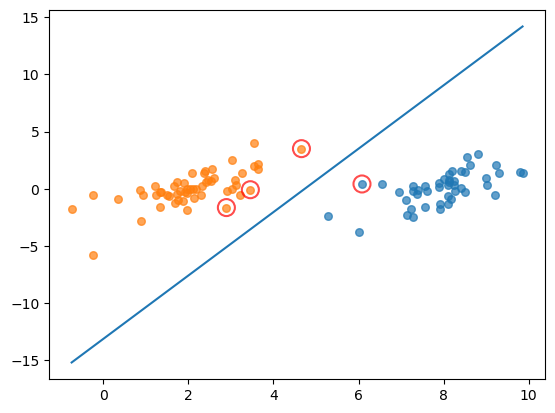

In [17]:
dataMat, labelMat = loadDataSet('./datasets/testSet.txt')
b, alphas = smoSimple(dataMat, labelMat, 0.6, 0.001, 40)
w = get_w(dataMat, labelMat, alphas)
showClassifer(dataMat, w, b)

In [18]:
class optStruct:
    """
	数据结构，维护所有需要操作的值
	Parameters：
		dataMatIn - 数据矩阵
		classLabels - 数据标签
		C - 松弛变量
		toler - 容错率
	"""

    def __init__(self, dataMatIn, classLabels, C, toler):
        self.X = dataMatIn  #数据矩阵
        self.labelMat = classLabels  #数据标签
        self.C = C  #松弛变量
        self.tol = toler  #容错率
        self.m = np.shape(dataMatIn)[0]  #数据矩阵行数
        self.alphas = np.mat(np.zeros((self.m, 1)))  #根据矩阵行数初始化alpha参数为0
        self.b = 0  #初始化b参数为0
        self.eCache = np.mat(np.zeros(
            (self.m, 2)))  #根据矩阵行数初始化虎误差缓存，第一列为是否有效的标志位，第二列为实际的误差E的值。


def loadDataSet(fileName):
    """
	读取数据
	Parameters:
	    fileName - 文件名
	Returns:
	    dataMat - 数据矩阵
	    labelMat - 数据标签
	"""
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():  #逐行读取，滤除空格等
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])  #添加数据
        labelMat.append(float(lineArr[2]))  #添加标签
    return dataMat, labelMat


def calcEk(oS, k):
    """
	计算误差
	Parameters：
		oS - 数据结构
		k - 标号为k的数据
	Returns:
	    Ek - 标号为k的数据误差
	"""
    fXk = float(
        np.multiply(oS.alphas, oS.labelMat).T * (oS.X * oS.X[k, :].T) + oS.b)
    Ek = fXk - float(oS.labelMat[k])
    return Ek


def selectJrand(i, m):
    """
	函数说明:随机选择alpha_j的索引值

	Parameters:
	    i - alpha_i的索引值
	    m - alpha参数个数
	Returns:
	    j - alpha_j的索引值
	"""
    j = i  #选择一个不等于i的j
    while (j == i):
        j = int(random.uniform(0, m))
    return j


def selectJ(i, oS, Ei):
    """
	内循环启发方式2
	Parameters：
		i - 标号为i的数据的索引值
		oS - 数据结构
		Ei - 标号为i的数据误差
	Returns:
	    j, maxK - 标号为j或maxK的数据的索引值
	    Ej - 标号为j的数据误差
	"""
    maxK = -1
    maxDeltaE = 0
    Ej = 0  #初始化
    oS.eCache[i] = [1, Ei]  #根据Ei更新误差缓存
    validEcacheList = np.nonzero(oS.eCache[:, 0].A)[0]  #返回误差不为0的数据的索引值
    if (len(validEcacheList)) > 1:  #有不为0的误差
        for k in validEcacheList:  #遍历,找到最大的Ek
            if k == i: continue  #不计算i,浪费时间
            Ek = calcEk(oS, k)  #计算Ek
            deltaE = abs(Ei - Ek)  #计算|Ei-Ek|
            if (deltaE > maxDeltaE):  #找到maxDeltaE
                maxK = k
                maxDeltaE = deltaE
                Ej = Ek
        return maxK, Ej  #返回maxK,Ej
    else:  #没有不为0的误差
        j = selectJrand(i, oS.m)  #随机选择alpha_j的索引值
        Ej = calcEk(oS, j)  #计算Ej
    return j, Ej  #j,Ej


def updateEk(oS, k):
    """
	计算Ek,并更新误差缓存
	Parameters：
		oS - 数据结构
		k - 标号为k的数据的索引值
	Returns:
		无
	"""
    Ek = calcEk(oS, k)  #计算Ek
    oS.eCache[k] = [1, Ek]  #更新误差缓存


def clipAlpha(aj, H, L):
    """
	修剪alpha_j
	Parameters:
	    aj - alpha_j的值
	    H - alpha上限
	    L - alpha下限
	Returns:
	    aj - 修剪后的alpah_j的值
	"""
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj


def innerL(i, oS):
    """
	优化的SMO算法
	Parameters：
		i - 标号为i的数据的索引值
		oS - 数据结构
	Returns:
		1 - 有任意一对alpha值发生变化
		0 - 没有任意一对alpha值发生变化或变化太小
	"""
    #步骤1：计算误差Ei
    Ei = calcEk(oS, i)
    #优化alpha,设定一定的容错率。
    if ((oS.labelMat[i] * Ei < -oS.tol) and
        (oS.alphas[i] < oS.C)) or ((oS.labelMat[i] * Ei > oS.tol) and
                                   (oS.alphas[i] > 0)):
        #使用内循环启发方式2选择alpha_j,并计算Ej
        j, Ej = selectJ(i, oS, Ei)
        #保存更新前的aplpha值，使用深拷贝
        alphaIold = oS.alphas[i].copy()
        alphaJold = oS.alphas[j].copy()
        #步骤2：计算上下界L和H
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L == H:
            print("L==H")
            return 0
        #步骤3：计算eta
        eta = 2.0 * oS.X[i, :] * oS.X[j, :].T - oS.X[i, :] * oS.X[
            i, :].T - oS.X[j, :] * oS.X[j, :].T
        if eta >= 0:
            print("eta>=0")
            return 0
        #步骤4：更新alpha_j
        oS.alphas[j] -= oS.labelMat[j] * (Ei - Ej) / eta
        #步骤5：修剪alpha_j
        oS.alphas[j] = clipAlpha(oS.alphas[j], H, L)
        #更新Ej至误差缓存
        updateEk(oS, j)
        if (abs(oS.alphas[j] - alphaJold) < 0.00001):
            print("alpha_j变化太小")
            return 0
        #步骤6：更新alpha_i
        oS.alphas[i] += oS.labelMat[j] * oS.labelMat[i] * (alphaJold -
                                                           oS.alphas[j])
        #更新Ei至误差缓存
        updateEk(oS, i)
        #步骤7：更新b_1和b_2
        b1 = oS.b - Ei - oS.labelMat[i] * (oS.alphas[i] - alphaIold) * oS.X[
            i, :] * oS.X[i, :].T - oS.labelMat[j] * (
                oS.alphas[j] - alphaJold) * oS.X[i, :] * oS.X[j, :].T
        b2 = oS.b - Ej - oS.labelMat[i] * (oS.alphas[i] - alphaIold) * oS.X[
            i, :] * oS.X[j, :].T - oS.labelMat[j] * (
                oS.alphas[j] - alphaJold) * oS.X[j, :] * oS.X[j, :].T
        #步骤8：根据b_1和b_2更新b
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]): oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]): oS.b = b2
        else: oS.b = (b1 + b2) / 2.0
        return 1
    else:
        return 0


def smoP(dataMatIn, classLabels, C, toler, maxIter):
    """
	完整的线性SMO算法
	Parameters：
		dataMatIn - 数据矩阵
		classLabels - 数据标签
		C - 松弛变量
		toler - 容错率
		maxIter - 最大迭代次数
	Returns:
		oS.b - SMO算法计算的b
		oS.alphas - SMO算法计算的alphas
	"""
    oS = optStruct(np.mat(dataMatIn),
                   np.mat(classLabels).transpose(), C, toler)  #初始化数据结构
    iter = 0  #初始化当前迭代次数
    entireSet = True
    alphaPairsChanged = 0
    while (iter
           < maxIter) and ((alphaPairsChanged > 0) or
                           (entireSet)):  #遍历整个数据集都alpha也没有更新或者超过最大迭代次数,则退出循环
        alphaPairsChanged = 0
        if entireSet:  #遍历整个数据集
            for i in range(oS.m):
                alphaPairsChanged += innerL(i, oS)  #使用优化的SMO算法
                print("全样本遍历:第%d次迭代 样本:%d, alpha优化次数:%d" %
                      (iter, i, alphaPairsChanged))
            iter += 1
        else:  #遍历非边界值
            nonBoundIs = np.nonzero(
                (oS.alphas.A > 0) * (oS.alphas.A < C))[0]  #遍历不在边界0和C的alpha
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i, oS)
                print("非边界遍历:第%d次迭代 样本:%d, alpha优化次数:%d" %
                      (iter, i, alphaPairsChanged))
            iter += 1
        if entireSet:  #遍历一次后改为非边界遍历
            entireSet = False
        elif (alphaPairsChanged == 0):  #如果alpha没有更新,计算全样本遍历
            entireSet = True
        print("迭代次数: %d" % iter)
    return oS.b, oS.alphas  #返回SMO算法计算的b和alphas


def showClassifer(dataMat, classLabels, w, b):
    """
    分类结果可视化
    """
    #绘制样本点
    data_plus = []  #正样本
    data_minus = []  #负样本
    for i in range(len(dataMat)):
        if classLabels[i] > 0:
            data_plus.append(dataMat[i])
        else:
            data_minus.append(dataMat[i])
    data_plus_np = np.array(data_plus)  #转换为numpy矩阵
    data_minus_np = np.array(data_minus)  #转换为numpy矩阵
    plt.scatter(np.transpose(data_plus_np)[0],
                np.transpose(data_plus_np)[1],
                s=30,
                alpha=0.7)  #正样本散点图
    plt.scatter(np.transpose(data_minus_np)[0],
                np.transpose(data_minus_np)[1],
                s=30,
                alpha=0.7)  #负样本散点图
    #绘制直线
    x1 = max(dataMat)[0]
    x2 = min(dataMat)[0]
    a1, a2 = w
    b = float(b)
    a1 = float(a1[0])
    a2 = float(a2[0])
    y1, y2 = (-b - a1 * x1) / a2, (-b - a1 * x2) / a2
    plt.plot([x1, x2], [y1, y2])
    #找出支持向量点
    for i, alpha in enumerate(alphas):
        if alpha > 0:
            x, y = dataMat[i]
            plt.scatter([x], [y],
                        s=150,
                        c='none',
                        alpha=0.7,
                        linewidth=1.5,
                        edgecolor='red')
    plt.show()


def calcWs(alphas, dataArr, classLabels):
    """
    计算w
    Parameters:
        dataArr - 数据矩阵
        classLabels - 数据标签
        alphas - alphas值
    Returns:
        w - 计算得到的w
    """
    X = np.mat(dataArr)
    labelMat = np.mat(classLabels).transpose()
    m, n = np.shape(X)
    w = np.zeros((n, 1))
    for i in range(m):
        w += np.multiply(alphas[i] * labelMat[i], X[i, :].T)
    return w



全样本遍历:第0次迭代 样本:0, alpha优化次数:1
全样本遍历:第0次迭代 样本:1, alpha优化次数:1
全样本遍历:第0次迭代 样本:2, alpha优化次数:2
全样本遍历:第0次迭代 样本:3, alpha优化次数:2
全样本遍历:第0次迭代 样本:4, alpha优化次数:3
全样本遍历:第0次迭代 样本:5, alpha优化次数:4
全样本遍历:第0次迭代 样本:6, alpha优化次数:5
全样本遍历:第0次迭代 样本:7, alpha优化次数:5
全样本遍历:第0次迭代 样本:8, alpha优化次数:6
全样本遍历:第0次迭代 样本:9, alpha优化次数:6
全样本遍历:第0次迭代 样本:10, alpha优化次数:6
全样本遍历:第0次迭代 样本:11, alpha优化次数:6
全样本遍历:第0次迭代 样本:12, alpha优化次数:6
全样本遍历:第0次迭代 样本:13, alpha优化次数:6
全样本遍历:第0次迭代 样本:14, alpha优化次数:6
全样本遍历:第0次迭代 样本:15, alpha优化次数:6
全样本遍历:第0次迭代 样本:16, alpha优化次数:6
全样本遍历:第0次迭代 样本:17, alpha优化次数:7
全样本遍历:第0次迭代 样本:18, alpha优化次数:8
全样本遍历:第0次迭代 样本:19, alpha优化次数:8
alpha_j变化太小
全样本遍历:第0次迭代 样本:20, alpha优化次数:8
alpha_j变化太小
全样本遍历:第0次迭代 样本:21, alpha优化次数:8
全样本遍历:第0次迭代 样本:22, alpha优化次数:8
全样本遍历:第0次迭代 样本:23, alpha优化次数:9
全样本遍历:第0次迭代 样本:24, alpha优化次数:9
alpha_j变化太小
全样本遍历:第0次迭代 样本:25, alpha优化次数:9
L==H
全样本遍历:第0次迭代 样本:26, alpha优化次数:9
全样本遍历:第0次迭代 样本:27, alpha优化次数:9
全样本遍历:第0次迭代 样本:28, alpha优化次数:9
L==H
全样本遍历:第0次迭代 样本:29, alpha优化次数:9
全样本遍历:第0次迭代 样本:30, alpha优化次数:9
全样本

C:\Users\12716\AppData\Local\Temp\ipykernel_43516\3953302816.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fXk = float(
C:\Users\12716\AppData\Local\Temp\ipykernel_43516\3953302816.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ek = fXk - float(oS.labelMat[k])
C:\Users\12716\AppData\Local\Temp\ipykernel_43516\3953302816.py:272: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b = float(b)


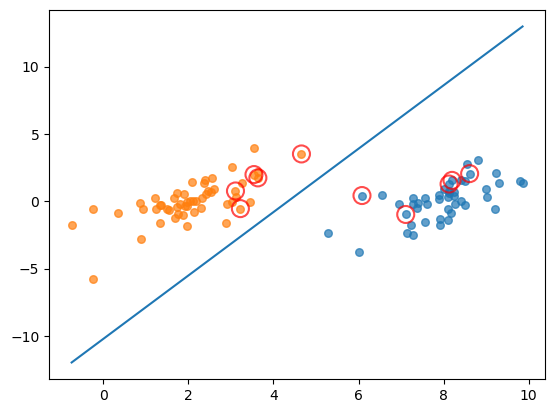

In [20]:
dataArr, classLabels = loadDataSet('./datasets/testSet.txt')
b, alphas = smoP(dataArr, classLabels, 0.6, 0.001, 40)
w = calcWs(alphas, dataArr, classLabels)
showClassifer(dataArr, classLabels, w, b)

## Non-linear SVM

In [1]:
class optStruct:
    """
	数据结构，维护所有需要操作的值
	Parameters：
		dataMatIn - 数据矩阵
		classLabels - 数据标签
		C - 松弛变量
		toler - 容错率
		kTup - 包含核函数信息的元组,第一个参数存放核函数类别，第二个参数存放必要的核函数需要用到的参数
	"""

    def __init__(self, dataMatIn, classLabels, C, toler, kTup):
        self.X = dataMatIn  #数据矩阵
        self.labelMat = classLabels  #数据标签
        self.C = C  #松弛变量
        self.tol = toler  #容错率
        self.m = np.shape(dataMatIn)[0]  #数据矩阵行数
        self.alphas = np.mat(np.zeros((self.m, 1)))  #根据矩阵行数初始化alpha参数为0
        self.b = 0  #初始化b参数为0
        self.eCache = np.mat(np.zeros(
            (self.m, 2)))  #根据矩阵行数初始化虎误差缓存，第一列为是否有效的标志位，第二列为实际的误差E的值。
        self.K = np.mat(np.zeros((self.m, self.m)))  #初始化核K
        for i in range(self.m):  #计算所有数据的核K
            self.K[:, i] = kernelTrans(self.X, self.X[i, :], kTup)


def kernelTrans(X, A, kTup):
    """
	通过核函数将数据转换更高维的空间
	Parameters：
		X - 数据矩阵
		A - 单个数据的向量
		kTup - 包含核函数信息的元组
	Returns:
	    K - 计算的核K
	"""
    m, n = np.shape(X)
    K = np.mat(np.zeros((m, 1)))
    if kTup[0] == 'lin': K = X * A.T  #线性核函数,只进行内积。
    elif kTup[0] == 'rbf':  #高斯核函数,根据高斯核函数公式进行计算
        for j in range(m):
            deltaRow = X[j, :] - A
            K[j] = deltaRow * deltaRow.T
        K = np.exp(K / (-1 * kTup[1]**2))  #计算高斯核K
    else:
        raise NameError('核函数无法识别')
    return K  #返回计算的核K


def loadDataSet(fileName):
    """
	读取数据
	Parameters:
	    fileName - 文件名
	Returns:
	    dataMat - 数据矩阵
	    labelMat - 数据标签
	"""
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():  #逐行读取，滤除空格等
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])  #添加数据
        labelMat.append(float(lineArr[2]))  #添加标签
    return dataMat, labelMat


def calcEk(oS, k):
    """
	计算误差
	Parameters：
		oS - 数据结构
		k - 标号为k的数据
	Returns:
	    Ek - 标号为k的数据误差
	"""
    fXk = float(np.multiply(oS.alphas, oS.labelMat).T * oS.K[:, k] + oS.b)
    Ek = fXk - float(oS.labelMat[k])
    return Ek


def selectJrand(i, m):
    """
	函数说明:随机选择alpha_j的索引值

	Parameters:
	    i - alpha_i的索引值
	    m - alpha参数个数
	Returns:
	    j - alpha_j的索引值
	"""
    j = i  #选择一个不等于i的j
    while (j == i):
        j = int(random.uniform(0, m))
    return j


def selectJ(i, oS, Ei):
    """
	内循环启发方式2
	Parameters：
		i - 标号为i的数据的索引值
		oS - 数据结构
		Ei - 标号为i的数据误差
	Returns:
	    j, maxK - 标号为j或maxK的数据的索引值
	    Ej - 标号为j的数据误差
	"""
    maxK = -1
    maxDeltaE = 0
    Ej = 0  #初始化
    oS.eCache[i] = [1, Ei]  #根据Ei更新误差缓存
    validEcacheList = np.nonzero(oS.eCache[:, 0].A)[0]  #返回误差不为0的数据的索引值
    if (len(validEcacheList)) > 1:  #有不为0的误差
        for k in validEcacheList:  #遍历,找到最大的Ek
            if k == i: continue  #不计算i,浪费时间
            Ek = calcEk(oS, k)  #计算Ek
            deltaE = abs(Ei - Ek)  #计算|Ei-Ek|
            if (deltaE > maxDeltaE):  #找到maxDeltaE
                maxK = k
                maxDeltaE = deltaE
                Ej = Ek
        return maxK, Ej  #返回maxK,Ej
    else:  #没有不为0的误差
        j = selectJrand(i, oS.m)  #随机选择alpha_j的索引值
        Ej = calcEk(oS, j)  #计算Ej
    return j, Ej  #j,Ej


def updateEk(oS, k):
    """
	计算Ek,并更新误差缓存
	Parameters：
		oS - 数据结构
		k - 标号为k的数据的索引值
	Returns:
		无
	"""
    Ek = calcEk(oS, k)  #计算Ek
    oS.eCache[k] = [1, Ek]  #更新误差缓存


def clipAlpha(aj, H, L):
    """
	修剪alpha_j
	Parameters:
	    aj - alpha_j的值
	    H - alpha上限
	    L - alpha下限
	Returns:
	    aj - 修剪后的alpah_j的值
	"""
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj


def innerL(i, oS):
    """
	优化的SMO算法
	Parameters：
		i - 标号为i的数据的索引值
		oS - 数据结构
	Returns:
		1 - 有任意一对alpha值发生变化
		0 - 没有任意一对alpha值发生变化或变化太小
	"""
    #步骤1：计算误差Ei
    Ei = calcEk(oS, i)
    #优化alpha,设定一定的容错率。
    if ((oS.labelMat[i] * Ei < -oS.tol) and
        (oS.alphas[i] < oS.C)) or ((oS.labelMat[i] * Ei > oS.tol) and
                                   (oS.alphas[i] > 0)):
        #使用内循环启发方式2选择alpha_j,并计算Ej
        j, Ej = selectJ(i, oS, Ei)
        #保存更新前的aplpha值，使用深拷贝
        alphaIold = oS.alphas[i].copy()
        alphaJold = oS.alphas[j].copy()
        #步骤2：计算上下界L和H
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L == H:
            print("L==H")
            return 0
        #步骤3：计算eta
        eta = 2.0 * oS.K[i, j] - oS.K[i, i] - oS.K[j, j]
        if eta >= 0:
            print("eta>=0")
            return 0
        #步骤4：更新alpha_j
        oS.alphas[j] -= oS.labelMat[j] * (Ei - Ej) / eta
        #步骤5：修剪alpha_j
        oS.alphas[j] = clipAlpha(oS.alphas[j], H, L)
        #更新Ej至误差缓存
        updateEk(oS, j)
        if (abs(oS.alphas[j] - alphaJold) < 0.00001):
            print("alpha_j变化太小")
            return 0
        #步骤6：更新alpha_i
        oS.alphas[i] += oS.labelMat[j] * oS.labelMat[i] * (alphaJold -
                                                           oS.alphas[j])
        #更新Ei至误差缓存
        updateEk(oS, i)
        #步骤7：更新b_1和b_2
        b1 = oS.b - Ei - oS.labelMat[i] * (oS.alphas[i] - alphaIold) * oS.K[
            i, i] - oS.labelMat[j] * (oS.alphas[j] - alphaJold) * oS.K[i, j]
        b2 = oS.b - Ej - oS.labelMat[i] * (oS.alphas[i] - alphaIold) * oS.K[
            i, j] - oS.labelMat[j] * (oS.alphas[j] - alphaJold) * oS.K[j, j]
        #步骤8：根据b_1和b_2更新b
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]): oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]): oS.b = b2
        else: oS.b = (b1 + b2) / 2.0
        return 1
    else:
        return 0


def smoP(dataMatIn, classLabels, C, toler, maxIter, kTup=('lin', 0)):
    """
	完整的线性SMO算法
	Parameters：
		dataMatIn - 数据矩阵
		classLabels - 数据标签
		C - 松弛变量
		toler - 容错率
		maxIter - 最大迭代次数
		kTup - 包含核函数信息的元组
	Returns:
		oS.b - SMO算法计算的b
		oS.alphas - SMO算法计算的alphas
	"""
    oS = optStruct(np.mat(dataMatIn),
                   np.mat(classLabels).transpose(), C, toler, kTup)  #初始化数据结构
    iter = 0  #初始化当前迭代次数
    entireSet = True
    alphaPairsChanged = 0
    while (iter
           < maxIter) and ((alphaPairsChanged > 0) or
                           (entireSet)):  #遍历整个数据集都alpha也没有更新或者超过最大迭代次数,则退出循环
        alphaPairsChanged = 0
        if entireSet:  #遍历整个数据集
            for i in range(oS.m):
                alphaPairsChanged += innerL(i, oS)  #使用优化的SMO算法
                print("全样本遍历:第%d次迭代 样本:%d, alpha优化次数:%d" %
                      (iter, i, alphaPairsChanged))
            iter += 1
        else:  #遍历非边界值
            nonBoundIs = np.nonzero(
                (oS.alphas.A > 0) * (oS.alphas.A < C))[0]  #遍历不在边界0和C的alpha
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i, oS)
                print("非边界遍历:第%d次迭代 样本:%d, alpha优化次数:%d" %
                      (iter, i, alphaPairsChanged))
            iter += 1
        if entireSet:  #遍历一次后改为非边界遍历
            entireSet = False
        elif (alphaPairsChanged == 0):  #如果alpha没有更新,计算全样本遍历
            entireSet = True
        print("迭代次数: %d" % iter)
    return oS.b, oS.alphas  #返回SMO算法计算的b和alphas


def testRbf(k1=1.3):
    """
	测试函数
	Parameters:
		k1 - 使用高斯核函数的时候表示到达率
	Returns:
	    无
	"""
    dataArr, labelArr = loadDataSet('./datasets/testSetRBF.txt')  #加载训练集
    b, alphas = smoP(dataArr, labelArr, 200, 0.0001, 100,
                     ('rbf', k1))  #根据训练集计算b和alphas
    datMat = np.mat(dataArr)
    labelMat = np.mat(labelArr).transpose()
    svInd = np.nonzero(alphas.A > 0)[0]  #获得支持向量
    sVs = datMat[svInd]
    labelSV = labelMat[svInd]
    print("支持向量个数:%d" % np.shape(sVs)[0])
    m, n = np.shape(datMat)
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs, datMat[i, :], ('rbf', k1))  #计算各个点的核
        predict = kernelEval.T * np.multiply(
            labelSV, alphas[svInd]) + b  #根据支持向量的点，计算超平面，返回预测结果
        if np.sign(predict) != np.sign(labelArr[i]):
            errorCount += 1  #返回数组中各元素的正负符号，用1和-1表示，并统计错误个数
    print("训练集错误率: %.2f%%" % ((float(errorCount) / m) * 100))  #打印错误率
    dataArr, labelArr = loadDataSet('./datasets/testSetRBF2.txt')  #加载测试集
    errorCount = 0
    datMat = np.mat(dataArr)
    labelMat = np.mat(labelArr).transpose()
    m, n = np.shape(datMat)
    for i in range(m):
        kernelEval = kernelTrans(sVs, datMat[i, :], ('rbf', k1))  #计算各个点的核
        predict = kernelEval.T * np.multiply(
            labelSV, alphas[svInd]) + b  #根据支持向量的点，计算超平面，返回预测结果
        if np.sign(predict) != np.sign(labelArr[i]):
            errorCount += 1  #返回数组中各元素的正负符号，用1和-1表示，并统计错误个数
    print("测试集错误率: %.2f%%" % ((float(errorCount) / m) * 100))  #打印错误率
#     showDataSet(dataMat, labelMat)


def showDataSet(dataMat, labelMat):
    """
	数据可视化
	Parameters:
	    dataMat - 数据矩阵
	    labelMat - 数据标签
	Returns:
	    无
	"""
    data_plus = []  #正样本
    data_minus = []  #负样本
    for i in range(len(dataMat)):
        if labelMat[i] > 0:
            data_plus.append(dataMat[i])
        else:
            data_minus.append(dataMat[i])
    data_plus_np = np.array(data_plus)  #转换为numpy矩阵
    data_minus_np = np.array(data_minus)  #转换为numpy矩阵
    plt.scatter(np.transpose(data_plus_np)[0],
                np.transpose(data_plus_np)[1])  #正样本散点图
    plt.scatter(
        np.transpose(data_minus_np)[0],
        np.transpose(data_minus_np)[1])  #负样本散点图
    plt.show()

In [4]:
testRbf()

C:\Users\12716\AppData\Local\Temp\ipykernel_46712\990437518.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fXk = float(np.multiply(oS.alphas, oS.labelMat).T * oS.K[:, k] + oS.b)
C:\Users\12716\AppData\Local\Temp\ipykernel_46712\990437518.py:79: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ek = fXk - float(oS.labelMat[k])


L==H
全样本遍历:第0次迭代 样本:0, alpha优化次数:0
全样本遍历:第0次迭代 样本:1, alpha优化次数:1
全样本遍历:第0次迭代 样本:2, alpha优化次数:2
全样本遍历:第0次迭代 样本:3, alpha优化次数:3
全样本遍历:第0次迭代 样本:4, alpha优化次数:3
全样本遍历:第0次迭代 样本:5, alpha优化次数:4
全样本遍历:第0次迭代 样本:6, alpha优化次数:4
全样本遍历:第0次迭代 样本:7, alpha优化次数:5
全样本遍历:第0次迭代 样本:8, alpha优化次数:5
全样本遍历:第0次迭代 样本:9, alpha优化次数:5
全样本遍历:第0次迭代 样本:10, alpha优化次数:6
全样本遍历:第0次迭代 样本:11, alpha优化次数:7
全样本遍历:第0次迭代 样本:12, alpha优化次数:7
全样本遍历:第0次迭代 样本:13, alpha优化次数:8
全样本遍历:第0次迭代 样本:14, alpha优化次数:9
全样本遍历:第0次迭代 样本:15, alpha优化次数:10
全样本遍历:第0次迭代 样本:16, alpha优化次数:11
全样本遍历:第0次迭代 样本:17, alpha优化次数:12
全样本遍历:第0次迭代 样本:18, alpha优化次数:13
全样本遍历:第0次迭代 样本:19, alpha优化次数:14
全样本遍历:第0次迭代 样本:20, alpha优化次数:14
全样本遍历:第0次迭代 样本:21, alpha优化次数:15
alpha_j变化太小
全样本遍历:第0次迭代 样本:22, alpha优化次数:15
alpha_j变化太小
全样本遍历:第0次迭代 样本:23, alpha优化次数:15
全样本遍历:第0次迭代 样本:24, alpha优化次数:16
全样本遍历:第0次迭代 样本:25, alpha优化次数:16
全样本遍历:第0次迭代 样本:26, alpha优化次数:17
全样本遍历:第0次迭代 样本:27, alpha优化次数:18
全样本遍历:第0次迭代 样本:28, alpha优化次数:19
全样本遍历:第0次迭代 样本:29, alpha优化次数:20
全样本遍历:第0次迭代 样本:30, alpha优化次数:20
全样本遍

训练集错误率: 9.00%
测试集错误率: 18.00%
